In [2]:
%pip install tqdm pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm

# Load the dataset
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Handle missing values
# For categorical features, replace with 'NA'
# For numerical features, replace with 0.0
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(exclude=['object']).columns.tolist()

# Remove target variable from numerical features if it's there
if 'converted' in numerical_features:
    numerical_features.remove('converted')

# Fill missing values
for col in categorical_features:
    df[col] = df[col].fillna('NA')
    
for col in numerical_features:
    df[col] = df[col].fillna(0.0)

# Check if missing values are handled
print("\nMissing values after handling:")
print(df.isnull().sum())

# Split the data into train/validation/test with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

print(f"\nTrain shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

Missing values in each column:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Missing values after handling:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Train shape: (876, 8)
Validation shape: (293, 8)
Test shape: (293, 8)


lead_score: AUC = 0.6145
number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
annual_income: AUC = 0.5520

The variable with the highest AUC is: number_of_courses_viewed with AUC = 0.7636
AUC on validation dataset: 0.817


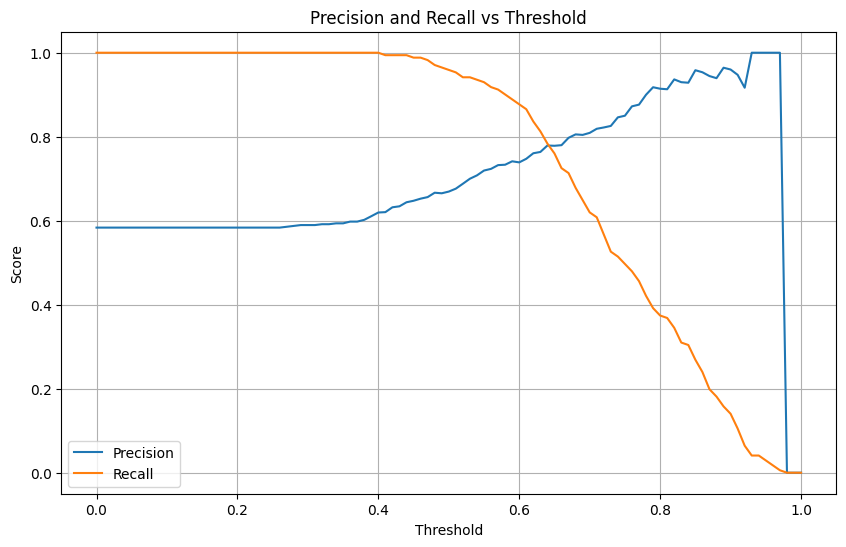

Precision and recall curves intersect at threshold: 0.980
Precision at this threshold: 0.000
Recall at this threshold: 0.000
Maximum F1 score: 0.812 at threshold: 0.570


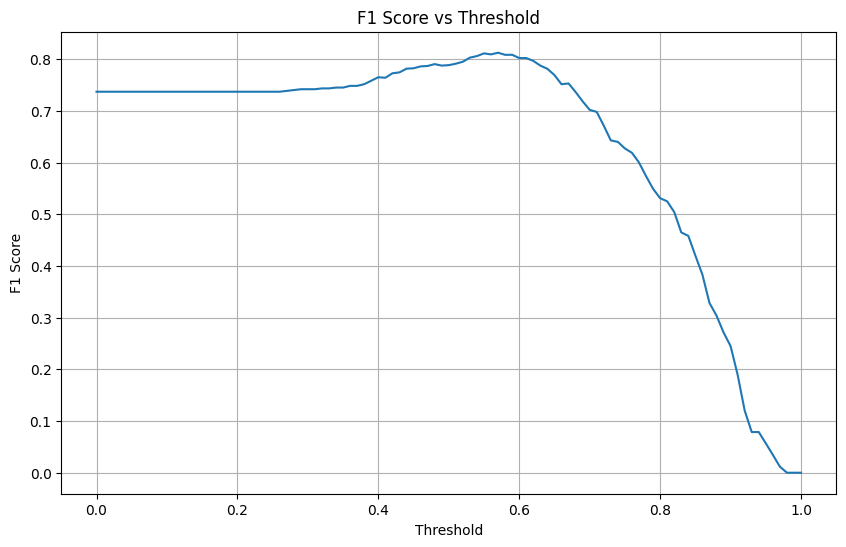

Scores for each fold: [0.8180473372781066, 0.8034963985594238, 0.842522687409441, 0.802355623100304, 0.8447608729298871]
Mean score: 0.822
Standard deviation of scores: 0.018
C=1e-06: Mean AUC = 0.561, Std = 0.043
C=0.001: Mean AUC = 0.867, Std = 0.015
C=1: Mean AUC = 0.822, Std = 0.018

Best C value: 0.001
Mean AUC: 0.867
Std AUC: 0.015


In [4]:
#question 1 to 6
# Question 1: ROC AUC feature importance
# For each numerical variable, compute AUC with the target variable
# If AUC < 0.5, invert the variable
# Find which of the 4 specified variables has the highest AUC

# Get the numerical variables from the original dataframe
numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for var in numerical_vars:
    # Compute AUC
    auc = roc_auc_score(y_train, df_train[var])
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
        auc_scores[var] = auc
        print(f"{var}: AUC = {auc:.4f} (inverted)")
    else:
        auc_scores[var] = auc
        print(f"{var}: AUC = {auc:.4f}")

# Find which variable has the highest AUC
best_var = max(auc_scores, key=auc_scores.get)
print(f"\nThe variable with the highest AUC is: {best_var} with AUC = {auc_scores[best_var]:.4f}")

# Question 2: Training the model
# Apply one-hot-encoding using DictVectorizer and train logistic regression
# Calculate AUC on validation dataset

# Convert dataframes to dictionaries
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

# Apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_val, y_pred)
print(f"AUC on validation dataset: {auc:.3f}")

# Question 3: Precision and Recall
# Evaluate model on thresholds from 0.0 to 1.0 with step 0.01
# Compute precision and recall for each threshold
# Plot them
# Find where precision and recall curves intersect

thresholds = np.arange(0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred >= t).astype(int)
    
    # Calculate precision and recall
    p = precision_score(y_val, y_pred_binary, zero_division=0)
    r = recall_score(y_val, y_pred_binary, zero_division=0)
    
    precisions.append(p)
    recalls.append(r)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find where precision and recall curves intersect
# We're looking for the threshold where the difference between precision and recall is minimal
diff = np.abs(np.array(precisions) - np.array(recalls))
idx = np.argmin(diff)
intersection_threshold = thresholds[idx]

print(f"Precision and recall curves intersect at threshold: {intersection_threshold:.3f}")
print(f"Precision at this threshold: {precisions[idx]:.3f}")
print(f"Recall at this threshold: {recalls[idx]:.3f}")

# Question 4: F1 score
# Compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
# Find threshold where F1 is maximal

f1_scores = []

for t in thresholds:
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred >= t).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_pred_binary, zero_division=0)
    f1_scores.append(f1)

# Find threshold where F1 is maximal
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_score:.3f} at threshold: {max_f1_threshold:.3f}")

# Plot F1 score vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()

# Question 5: 5-Fold CV
# Use KFold to evaluate model on 5 different folds
# Calculate standard deviation of scores across folds

# Combine train and validation data for cross-validation
df_full_train = pd.concat([df_train, df_val], ignore_index=True)
y_full_train = np.concatenate([y_train, y_val])

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Lists to store scores
scores = []

# Iterate over different folds
for train_idx, val_idx in kfold.split(df_full_train):
    # Split data
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]
    
    # Convert to dictionaries
    train_dict = df_train_fold.to_dict(orient='records')
    val_dict = df_val_fold.to_dict(orient='records')
    
    # Apply one-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dict)
    X_val_fold = dv.transform(val_dict)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc)

print(f"Scores for each fold: {scores}")
print(f"Mean score: {np.mean(scores):.3f}")
print(f"Standard deviation of scores: {np.std(scores):.3f}")

# Question 6: Hyperparameter Tuning
# Use 5-Fold cross-validation to find best parameter C
# Iterate over C values: [0.000001, 0.001, 1]
# Compute mean score and std for each C
# Select C with best mean score, breaking ties as specified

C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
    scores = []
    
    # Initialize KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # Iterate over different folds
    for train_idx, val_idx in kfold.split(df_full_train):
        # Split data
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = y_full_train[train_idx]
        y_val_fold = y_full_train[val_idx]
        
        # Convert to dictionaries
        train_dict = df_train_fold.to_dict(orient='records')
        val_dict = df_val_fold.to_dict(orient='records')
        
        # Apply one-hot encoding
        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_dict)
        X_val_fold = dv.transform(val_dict)
        
        # Train model with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        
        # Calculate AUC
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        scores.append(auc)
    
    # Store results
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results[C] = {
        'mean': mean_score,
        'std': std_score,
        'scores': scores
    }
    
    print(f"C={C}: Mean AUC = {mean_score:.3f}, Std = {std_score:.3f}")

# Find C with best mean score
best_C = max(results, key=lambda x: (results[x]['mean'], -results[x]['std'], -x))
print(f"\nBest C value: {best_C}")
print(f"Mean AUC: {results[best_C]['mean']:.3f}")
print(f"Std AUC: {results[best_C]['std']:.3f}")